# Unconditional image generation

Unconditional image generation is a relatively straightforward task. The model only generates images - without any additional context like text or an image - resembling the training data it was trained on.

The [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) is the easiest way to use a pre-trained diffusion system for inference.

Start by creating an instance of [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) and specify which pipeline checkpoint you would like to download.
You can use any of the 🧨 Diffusers [checkpoints](https://huggingface.co/models?library=diffusers&sort=downloads) from the Hub (the checkpoint you'll use generates images of butterflies).

<Tip>

💡 Want to train your own unconditional image generation model? Take a look at the training [guide](https://huggingface.co/docs/diffusers/main/en/using-diffusers/training/unconditional_training) to learn how to generate your own images.

</Tip>

In this guide, you'll use [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) for unconditional image generation with [DDPM](https://arxiv.org/abs/2006.11239):

In [1]:
!pip3 install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.6 MB/s eta 0:00:00


In [2]:
!pip3 install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 18.8 MB/s eta 0:00:00


In [3]:

import transformers


In [4]:
!pip install diffusers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00


In [5]:

from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
from pprint import pprint
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
from transformers import TFAutoModelForMaskedLM, AutoTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer, top_k_top_p_filtering
from torch import nn
from accelerate import Accelerator
from diffusers import DiffusionPipeline

In [6]:
from diffusers import DiffusionPipeline

generator = DiffusionPipeline.from_pretrained("anton-l/ddpm-butterflies-128")

unet/diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

The [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline) downloads and caches all modeling, tokenization, and scheduling components.
Because the model consists of roughly 1.4 billion parameters, we strongly recommend running it on a GPU.
You can move the generator object to a GPU, just like you would in PyTorch:

In [7]:
generator.to("cuda")

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.17.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

Now you can use the `generator` to generate an image:

In [8]:
image = generator().images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

The output is by default wrapped into a [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=image#the-image-class) object.

You can save the image by calling:

In [10]:
image.save("generated_image.png")

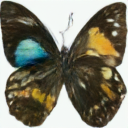

In [11]:
image

Try out the Spaces below, and feel free to play around with the inference steps parameter to see how it affects the image quality!

<iframe
	src="https://stevhliu-ddpm-butterflies-128.hf.space"
	frameborder="0"
	width="850"
	height="500"
></iframe>

https://huggingface.co/docs/diffusers/using-diffusers/unconditional_image_generation
